In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [2]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400

# Расходы на логистику
EU_LOGISTIC_COST = 30 # в Европу
CN_LOGISTIC_COST = 130 # в Китай

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%

In [3]:
all_dfs = []
for y in ['2019', '2020', '2021', '2022']:
    for m in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        url = f'https://www.lgm.gov.my/webv2api/api/rubberprice/month={m}&year={y}'
        res = requests.get(url)
        rj = res.json()
        temp_df = pd.json_normalize(rj)
        all_dfs.append(temp_df)

In [4]:
main_df = pd.concat(all_dfs)
main_df

,date,grade,masa,rm,us,tone
0,2019-01-31,SMR CV,Noon,770.00,191.30,Quiet
1,2019-01-31,SMR L,Noon,750.00,186.35,Quiet
2,2019-01-31,SMR 5,Noon,549.50,136.50,Quiet
3,2019-01-31,SMR GP,Noon,546.50,135.80,Quiet
4,2019-01-31,SMR 10,Noon,539.50,134.05,Quiet
...,...,...,...,...,...,...
100,2022-08-01,SMR 5,Noon,680.50,155.45,Quiet
101,2022-08-01,SMR GP,Noon,677.50,154.80,Quiet
102,2022-08-01,SMR 10,Noon,670.50,153.20,Quiet
103,2022-08-01,SMR 20,Noon,668.50,152.75,Quiet


In [5]:
id = main_df.grade.apply(lambda x: 'SMR 20' in x)
df_smr_20 = main_df[id]

In [6]:
df_smr_20 = df_smr_20[['date', 'us']]
df_smr_20

,date,us
5,2019-01-31,133.55
12,2019-01-30,133.75
19,2019-01-29,133.05
26,2019-01-28,134.40
33,2019-01-25,134.10
...,...,...
75,2022-08-05,151.70
82,2022-08-04,151.90
89,2022-08-03,153.10
96,2022-08-02,150.95


In [7]:
df_smr_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 5 to 103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    882 non-null    object
 1   us      882 non-null    object
dtypes: object(2)
memory usage: 20.7+ KB


In [8]:
df_smr_20['us'] = df_smr_20.us.astype(float)
df_smr_20['date'] =  pd.to_datetime(df_smr_20['date'])

In [9]:
df_smr_20['price_eu'] = PRODUCTION_COST + EU_LOGISTIC_COST + df_smr_20.us
df_smr_20['price_eu_ma'] = (PRODUCTION_COST + EU_LOGISTIC_COST + df_smr_20.us).rolling(window=3).mean()
df_smr_20['price_cn'] = PRODUCTION_COST + CN_LOGISTIC_COST + df_smr_20.us

In [10]:
df_smr_20

,date,us,price_eu,price_eu_ma,price_cn
5,2019-01-31,133.55,563.55,NaN,663.55
12,2019-01-30,133.75,563.75,NaN,663.75
19,2019-01-29,133.05,563.05,563.450000,663.05
26,2019-01-28,134.40,564.40,563.733333,664.40
33,2019-01-25,134.10,564.10,563.850000,664.10
...,...,...,...,...,...
75,2022-08-05,151.70,581.70,584.350000,681.70
82,2022-08-04,151.90,581.90,583.116667,681.90
89,2022-08-03,153.10,583.10,582.233333,683.10
96,2022-08-02,150.95,580.95,581.983333,680.95


In [11]:
df_smr_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 5 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         882 non-null    datetime64[ns]
 1   us           882 non-null    float64       
 2   price_eu     882 non-null    float64       
 3   price_eu_ma  880 non-null    float64       
 4   price_cn     882 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 41.3 KB


In [12]:
df_smr_20 = df_smr_20.reset_index(drop=True)
print(df_smr_20.to_string())

          date      us  price_eu  price_eu_ma  price_cn
0   2019-01-31  133.55    563.55          NaN    663.55
1   2019-01-30  133.75    563.75          NaN    663.75
2   2019-01-29  133.05    563.05   563.450000    663.05
3   2019-01-28  134.40    564.40   563.733333    664.40
4   2019-01-25  134.10    564.10   563.850000    664.10
5   2019-01-24  134.35    564.35   564.283333    664.35
6   2019-01-23  134.30    564.30   564.250000    664.30
7   2019-01-22  137.20    567.20   565.283333    667.20
8   2019-01-18  135.65    565.65   565.716667    665.65
9   2019-01-17  135.10    565.10   565.983333    665.10
10  2019-01-16  136.10    566.10   565.616667    666.10
11  2019-01-15  135.25    565.25   565.483333    665.25
12  2019-01-14  135.20    565.20   565.516667    665.20
13  2019-01-11  137.95    567.95   566.133333    667.95
14  2019-01-10  138.10    568.10   567.083333    668.10
15  2019-01-09  140.90    570.90   568.983333    670.90
16  2019-01-08  138.90    568.90   569.300000   

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

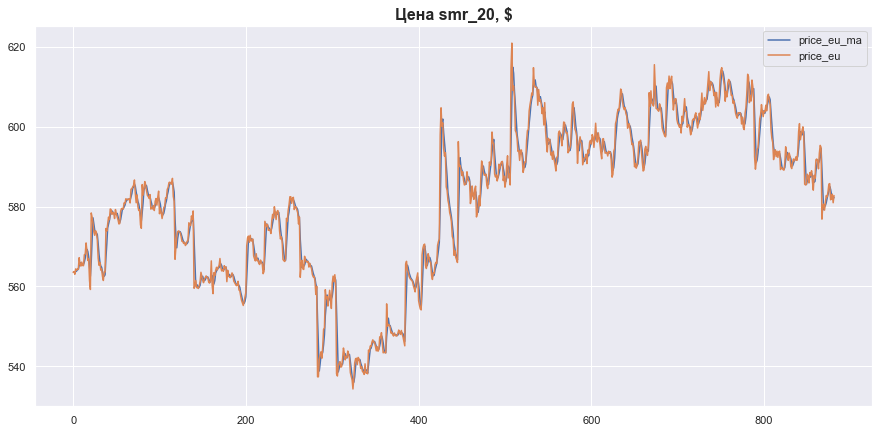

In [14]:
# График с базовой ценой(на заводе)
plt.title('Цена smr_20, $', fontsize=16, fontweight='bold')
plt.plot(df_smr_20['price_eu_ma'], label='price_eu_ma')
plt.plot(df_smr_20['price_eu'], label='price_eu')
plt.legend()
plt.show()

In [15]:
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'formula': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'formula': 'monthly'}}

In [16]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

In [17]:
import os

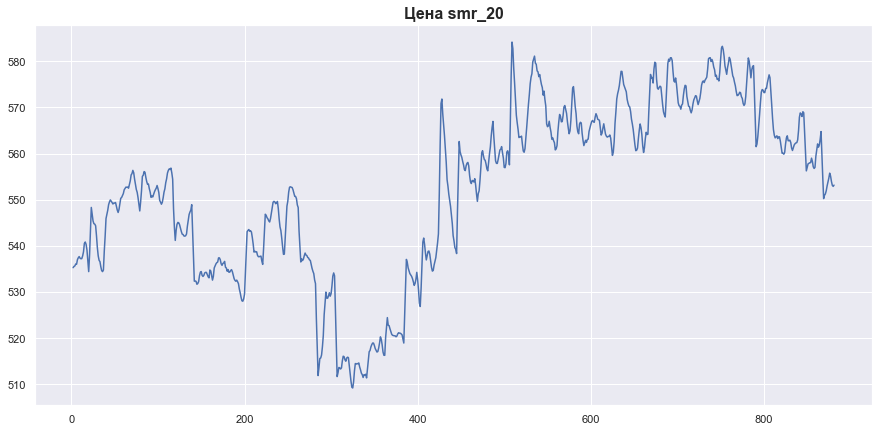

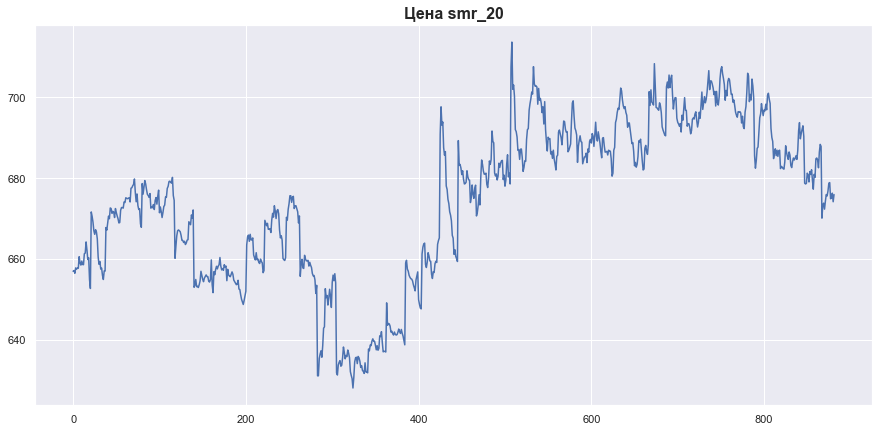

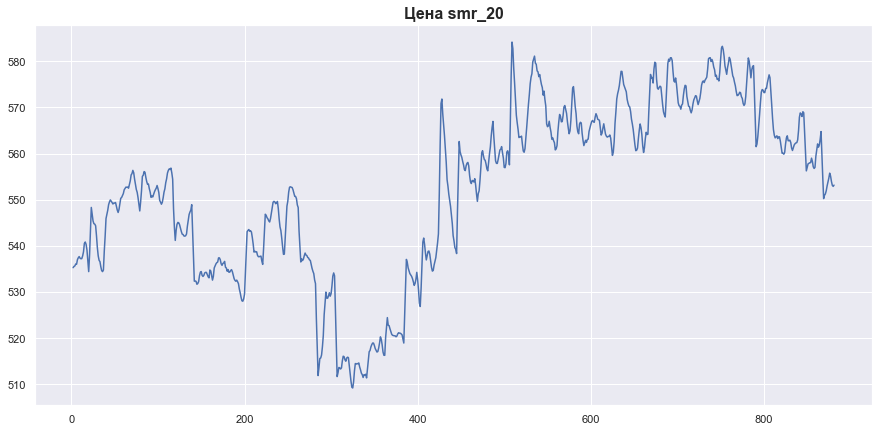

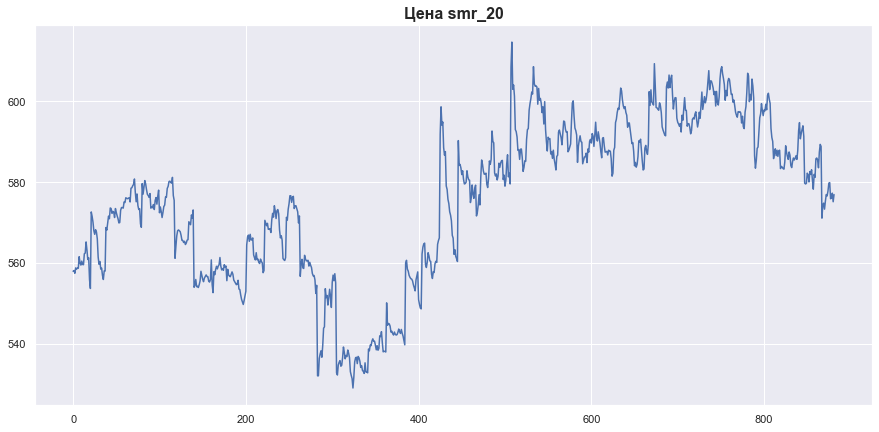

In [18]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():
        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = df_smr_20['price_eu'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = df_smr_20['price_eu_ma'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = df_smr_20['price_cn'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена smr_20', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_wbp.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

In [19]:
price_proposals_path = 'client_wbp_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

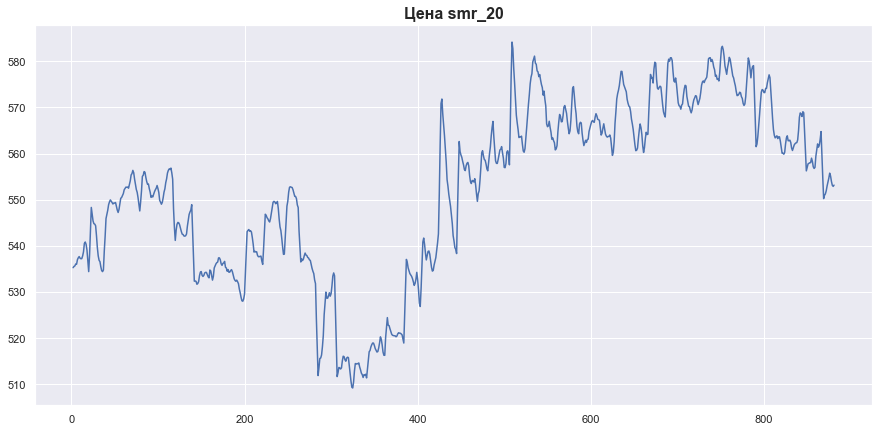

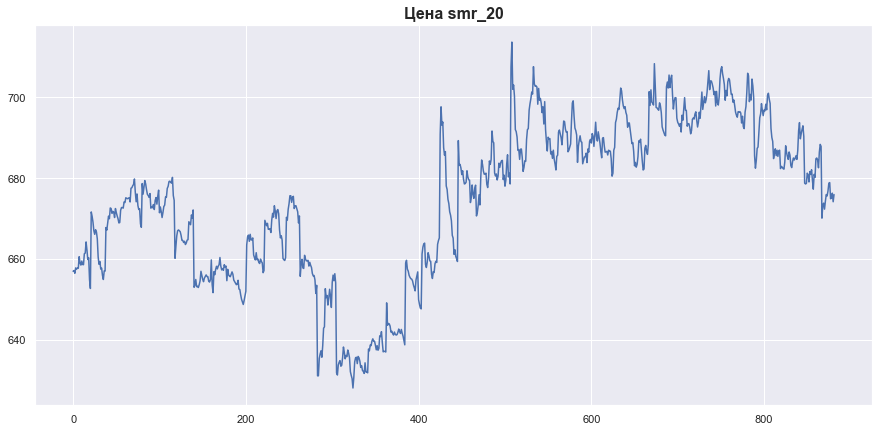

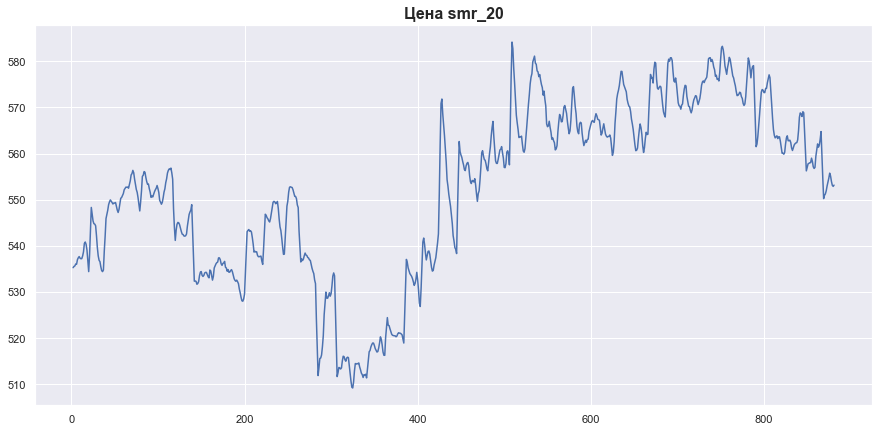

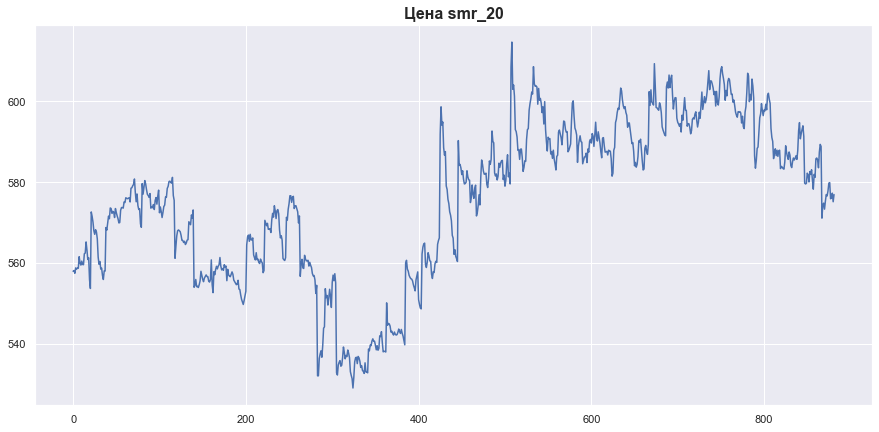

In [20]:
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_smr_20_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = df_smr_20['price_eu'] * (1-disc)
        elif v.get('formula') == 'moving_average':
            client_price = df_smr_20['price_eu_ma'] * (1-disc)

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = df_smr_20['price_cn'] * (1-disc)
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена smr_20', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.
Важный момент: данные для расчета скрипт должен подтягивать сам.
​
​
* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

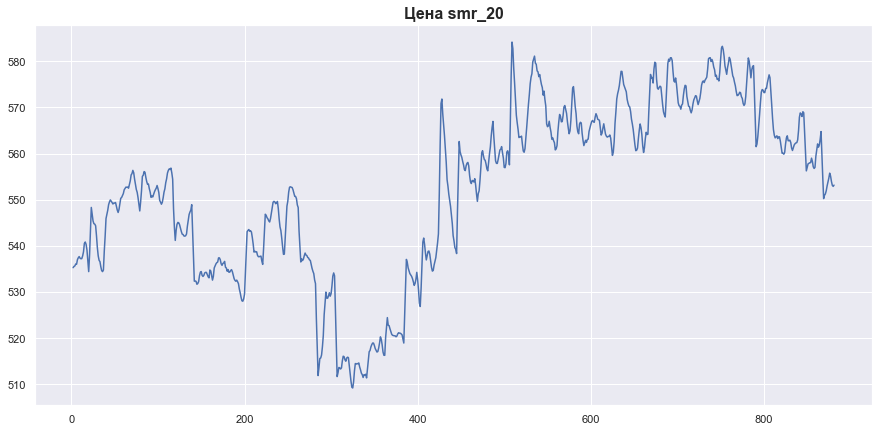

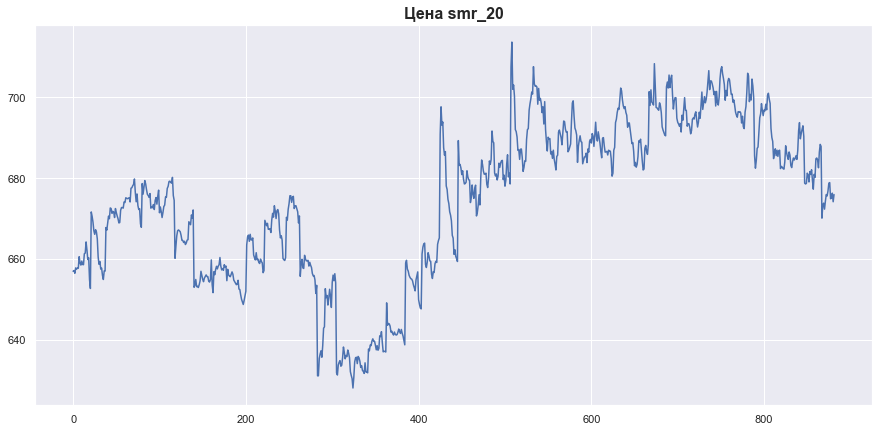

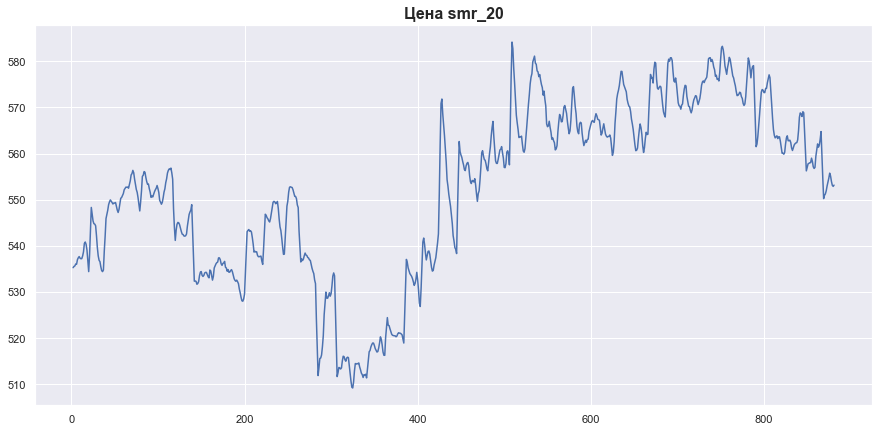

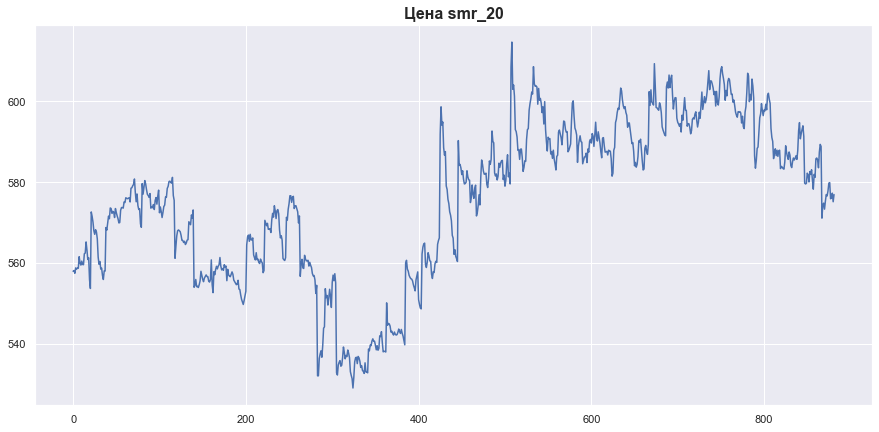

In [21]:
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_mwp_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = df_smr_20['price_eu'] * (1-disc)
        elif v.get('formula') == 'moving_average':
            client_price = df_smr_20['price_eu_ma'] * (1-disc)

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = df_smr_20['price_cn'] * (1-disc)
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена smr_20', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")